## Time series Forcasting 

## Introduction

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('bmh')


In [2]:
#Modeling and validation libraries
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [3]:
#read the files. 
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")

In [4]:
#duplicate the data file so it can be called later.
train_original = train.copy()
test_original  = test.copy()

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [6]:
#check the size of the data 
train.shape, test.shape

((18288, 3), (5112, 2))

In [7]:
#convert the date form from object to datetime format in the train and test data set.
train['Datetime']            = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
test['Datetime']             = pd.to_datetime(test.Datetime, format ='%d-%m-%Y %H:%M')
train_original['Datetime']   = pd.to_datetime(train_original.Datetime, format ='%d-%m-%Y %H:%M')
test_original['Datetime']    = pd.to_datetime(test_original.Datetime, format ='%d-%m-%Y %H:%M')

In [8]:
test.index = pd.to_datetime(test['Datetime'])

In [9]:
test

ID            Datetime
Datetime                                      
2014-09-26 00:00:00  18288 2014-09-26 00:00:00
2014-09-26 01:00:00  18289 2014-09-26 01:00:00
2014-09-26 02:00:00  18290 2014-09-26 02:00:00
2014-09-26 03:00:00  18291 2014-09-26 03:00:00
2014-09-26 04:00:00  18292 2014-09-26 04:00:00
...                    ...                 ...
2015-04-26 19:00:00  23395 2015-04-26 19:00:00
2015-04-26 20:00:00  23396 2015-04-26 20:00:00
2015-04-26 21:00:00  23397 2015-04-26 21:00:00
2015-04-26 22:00:00  23398 2015-04-26 22:00:00
2015-04-26 23:00:00  23399 2015-04-26 23:00:00

[5112 rows x 2 columns]

## Feature Extration

### Use the hypothesis listed to make the feature extraction move. 

In [10]:
#We highlited that weekend will have less air travel than weekdays. 
for i in (train, test, train_original, test_original):
    i['year']   =   i.Datetime.dt.year
    i['month']  =   i.Datetime.dt.month
    i['day']    =   i.Datetime.dt.day
    i['Hour']   =   i.Datetime.dt.hour

In [11]:
#N.B To identify weekends 5 and 6 are weekendas
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [12]:
#function to classify the records
#weekend is 1
#week day is 0
def rowclass(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1 
    else:
        return 0

#apply the function rowclass
temp2 = train['Datetime'].apply(rowclass)
train['week_day_end'] = temp2

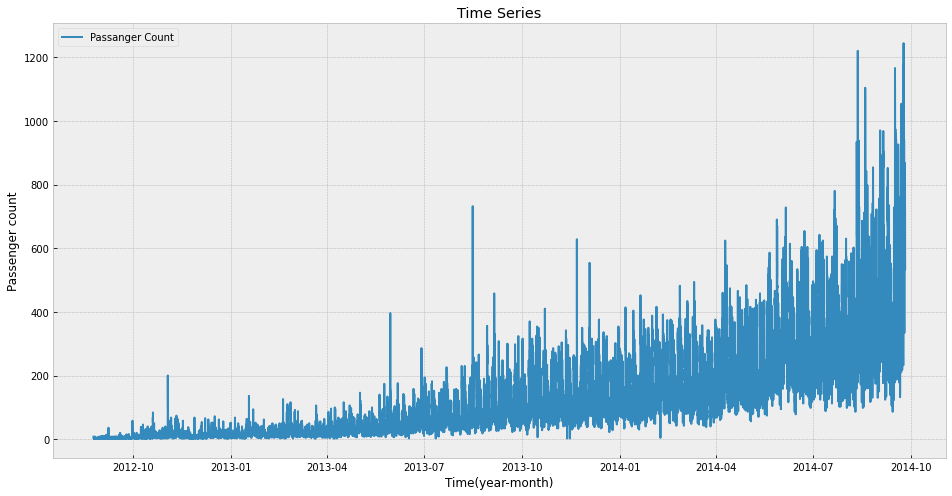

In [13]:
#view time series
train.index = train['Datetime']
#remove the id variable
trainN = train.drop('ID',1)

trainV = trainN['Count']
plt.figure(figsize = (16,8))
plt.plot(trainV, label ='Passanger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger count')
plt.legend(loc ='best')

### Exploratory Data Analysis

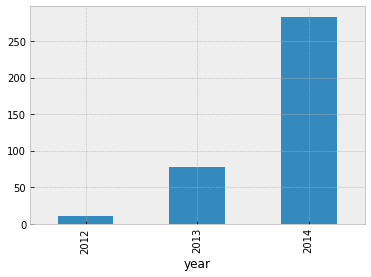

In [14]:
#Verify hypothesis 
train.groupby('year')['Count'].mean().plot.bar()

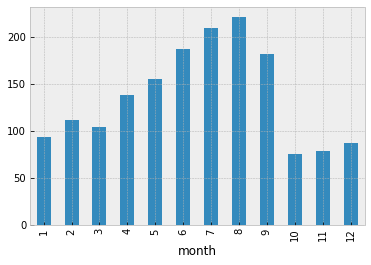

In [15]:
train.groupby('month')['Count'].mean().plot.bar()

This disproves the Hypothesis that during christmas the traffic is high

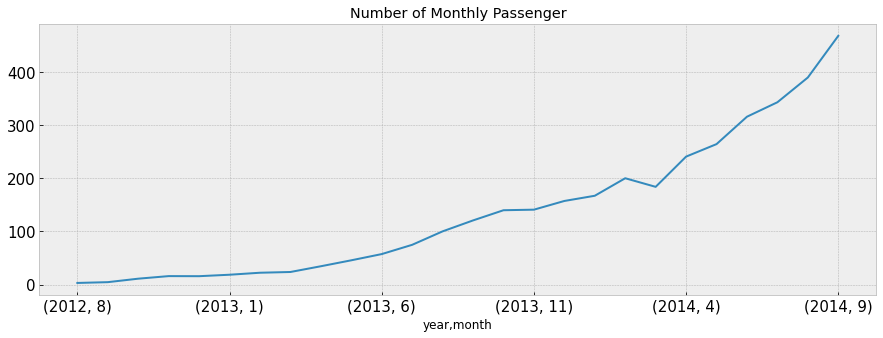

In [16]:
temp =train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15, 5), title = 'Number of Monthly Passenger', fontsize =15)

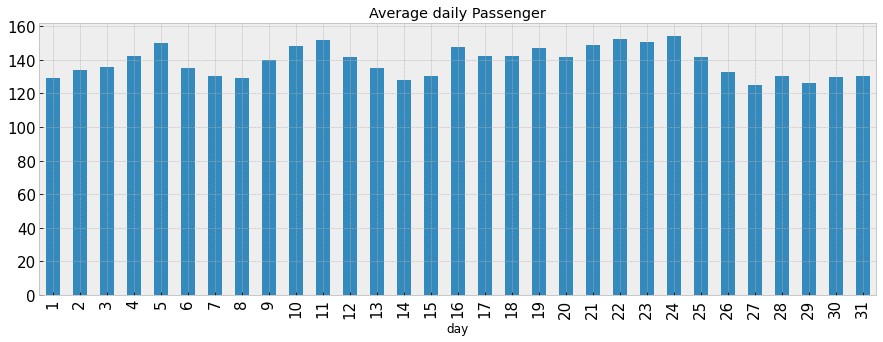

In [17]:
#observe the average dayily passenger in a month
train.groupby('day')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

Not much insight is gotton from the daily chart.
we go ahead to plot the monthly chart

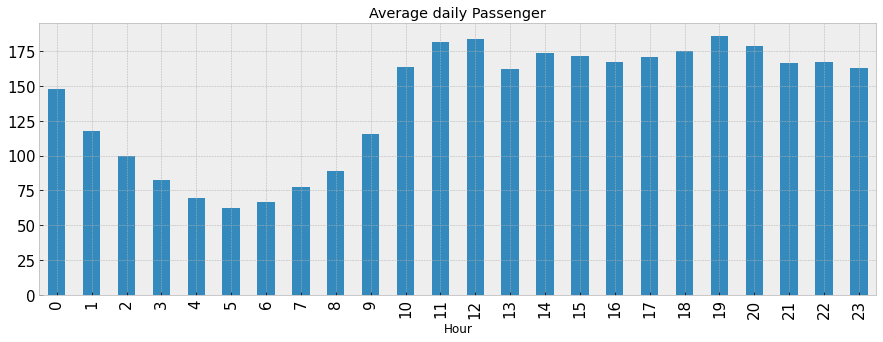

In [18]:
train.groupby('Hour')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

### Note this provides a worthy insight unlike the daily average. the Hourly shows a peak  tile at 7pm. then a decline till Lowest at 5am. then stedy rise again. Points to note 
-7pm(19:00hrs) is the peak hour \
-5am is the les busiest hour \
-11 & 12PM are also busy hours 

Next to Validate another Hypothis which states that there will be more traffic in the week days compared to weekend

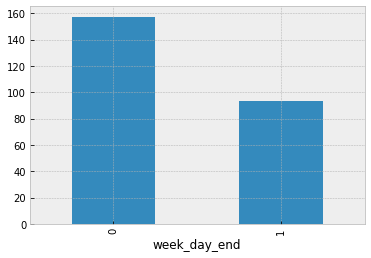

In [19]:
train.groupby('week_day_end')['Count'].mean().plot.bar()

As seen above the hypothesis is validated. the flight in the weekday is higher then the week end. 

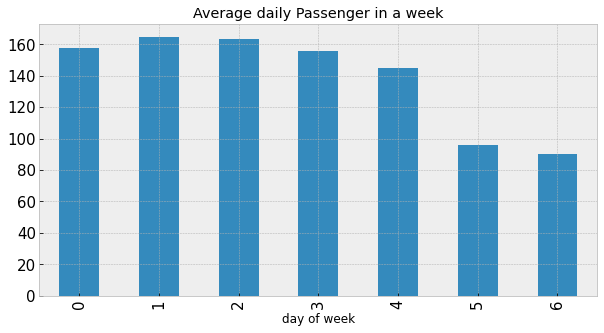

In [20]:
#average daily trafic in a week
train.groupby('day of week')['Count'].mean().plot.bar(figsize = (10, 5), title = 'Average daily Passenger in a week', fontsize =15)

The observation from this chart is that the hypothesis i correct. Customers are more on week days than week ends.

In [21]:
#drop the id column, it isn't necessary in this instance 
train = train.drop('ID',1)

In [22]:
train.Timestamp = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
train.index =   train.Timestamp

In [23]:
#hourly time series
hourly = train.resample('H').mean()
#convert to daily mean
daily = train.resample('D').mean()
#convert to weekly mean
weekly = train.resample('W').mean()
#convert to monthly mean
Monthly = train.resample('M').mean()

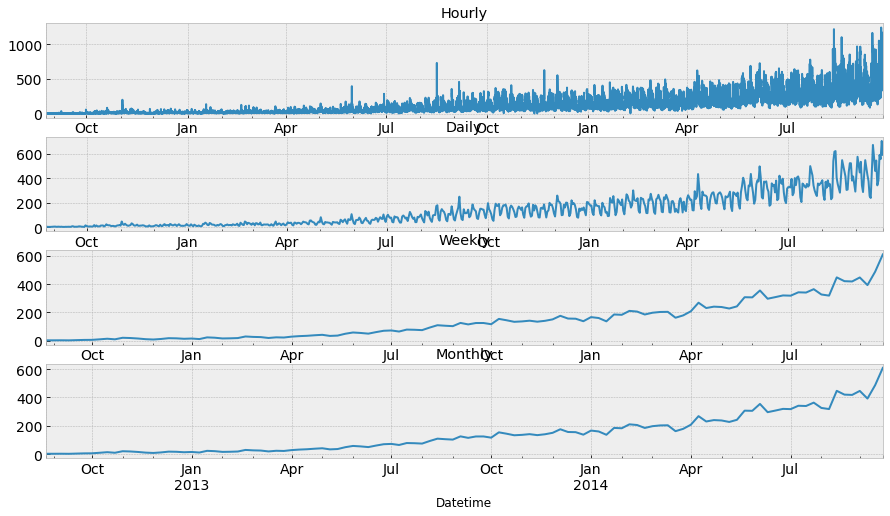

In [24]:
#plot to view the various charts
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize =(15,8), title ='Hourly', fontsize =14, ax =axs[0])
daily.Count.plot(figsize =(15,8), title ='Daily', fontsize =14, ax =axs[1])
weekly.Count.plot(figsize = (15,8), title ='Weekly', fontsize = 14, ax =axs[2])
weekly.Count.plot(figsize =(15,8), title ='Monthly', fontsize = 14, ax =axs[3])

plt.show()

The chart becomes smoother as it increase form daily to weekly and monthly.
htw best time series to use for the test data set is daily. 

The Hypothesis has being fully validated. \
Just one was refuted which is the 

Split the data set

In [25]:
#split the data into Train and validation 
#choose 4months for validation to accuratly cover all the possible data points.
Train = train.loc['2012-08-25': '2014-06-24'] 
valid = train.loc['2014-06-25':'2014-09-25']



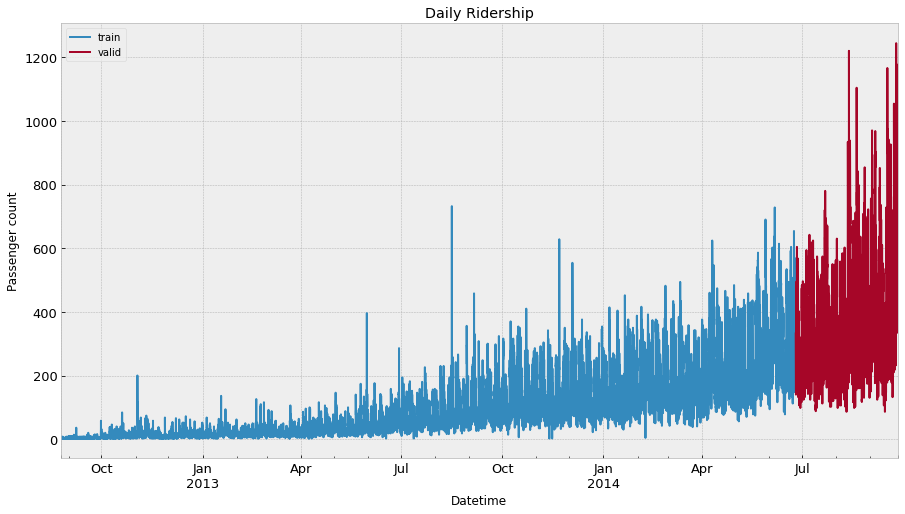

In [26]:

#Plot to visualize the train and the validation data
Train.Count.plot(figsize =  (15,8), title ='Daily Ridership', fontsize =14,label ='train')
valid.Count.plot(figsize =(15,8), title ='Daily Ridership', fontsize =13,label ='valid')
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

Modelling technique
 For modelling in this Time series we shall look out four method.\ 
-Naive Approach\
-Moving average\
-Simple Exponential Smoothing\
-Holts’S Linear Trend

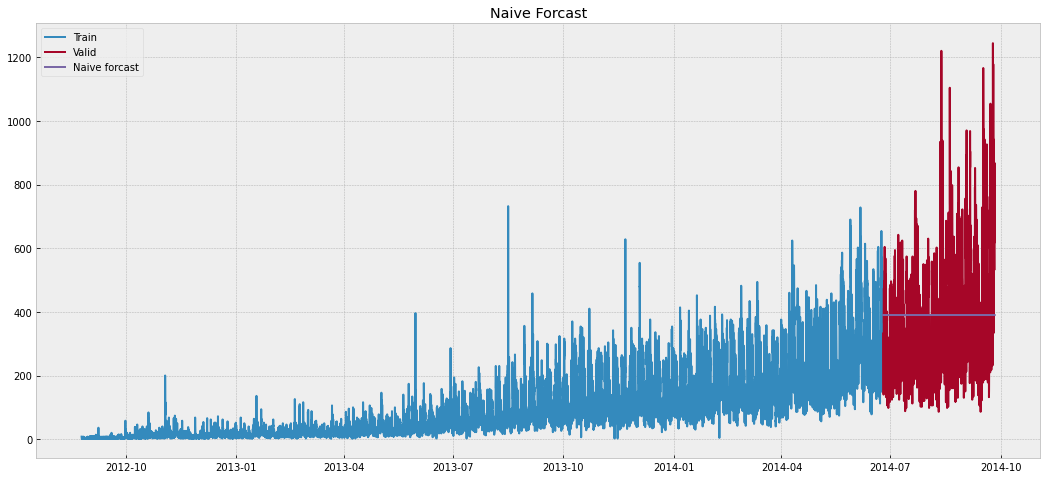

In [27]:
#Naive Approach
tt =np.asarray(Train.Count)
y_hat =valid.copy()
y_hat['naive'] = tt[len(tt)-1]
plt.figure(figsize=(18,8))
plt.plot(Train.index, Train['Count'], label ='Train')
plt.plot(valid.index, valid['Count'], label ='Valid')
plt.plot(y_hat.index, y_hat['naive'], label ='Naive forcast')
plt.legend(loc ='best')
plt.title('Naive Forcast')
plt.show()

The Naive prediction is the horizontal line at the validation data set

In [28]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat.naive))
print(rms)

186.37368520699056


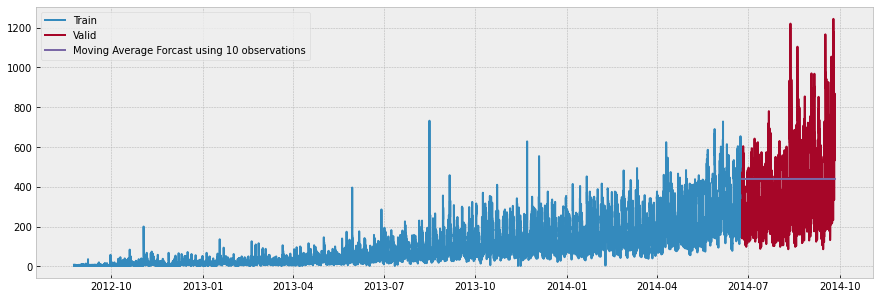

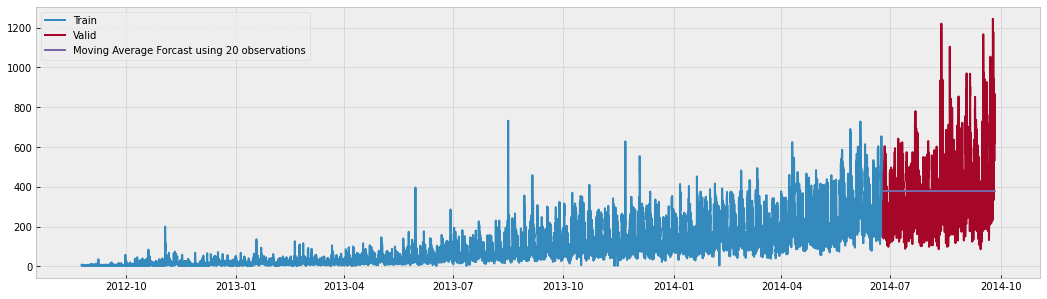

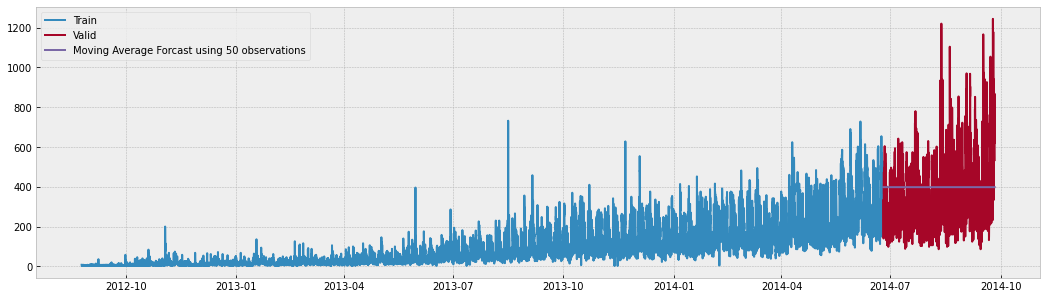

In [29]:
# Trying the seecond Moving Average Approach
#taking the average of a few point 10, 20, 50
y_hat_avg =valid.copy()
y_hat_avg['moving_avg_forcast'] =  Train['Count'].rolling(10).mean().iloc[-1]
#average of the last 10 observations 
plt.figure(figsize =(15,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 10 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(20).mean().iloc[-1]
#average for the last 20 observations
plt.figure(figsize=(18,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 20 observations')
plt.legend(loc='best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(50).mean().iloc[-1]
#average for the last 50 observations
plt.figure(figsize=(18,5))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'], label ='Moving Average Forcast using 50 observations')
plt.legend(loc='best')
plt.show()

In [30]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat_avg.moving_avg_forcast))
print(rms)

186.5773761711873


Simple Exponential smoothing model



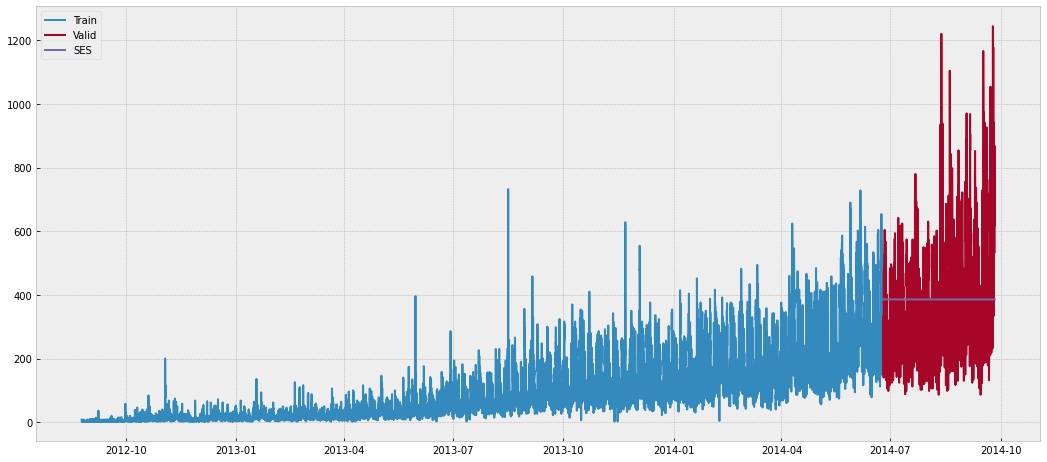

In [31]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level =0.6, optimized =True)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(18,8))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['SES'], label ='SES')
plt.legend(loc='best')
plt.show()

In [32]:
#Calculate the RMSE 
rms = sqrt(mse(valid.Count, y_hat_avg.SES))
print(rms)

186.40944652452376


Holt's Linear Trens Model

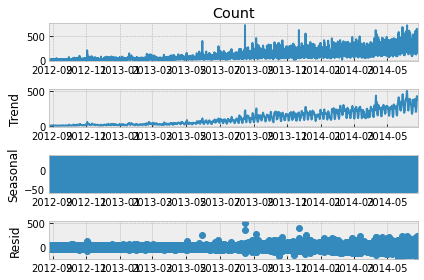

In [33]:
sm.tsa.seasonal_decompose(Train.Count).plot()
result =sm.tsa.stattools.adfuller(train.Count)
plt.show()

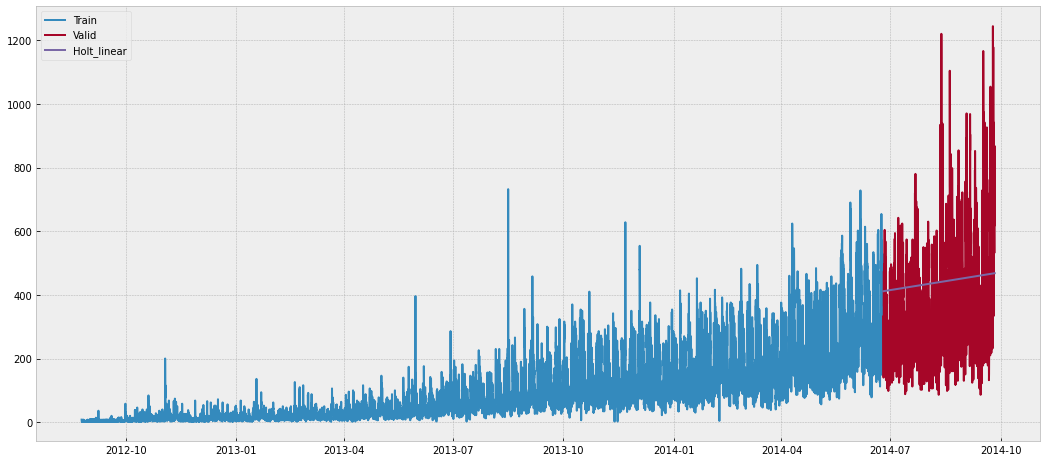

In [34]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level =0.2, smoothing_slope = 0 ) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(18,8))
plt.plot(Train['Count'], label ='Train')
plt.plot(valid['Count'], label ='Valid')
plt.plot(y_hat_avg['Holt_linear'], label ='Holt_linear')
plt.legend(loc='best')
plt.show()

In [35]:
rms_holt = sqrt(mse(valid.Count,y_hat_avg.Holt_linear))
print(rms_holt)


188.80416185308766


Rms value decreased we can now go further for prediction

## Prediction

In [36]:
#now lets us the best model for prediction
predict =fit1.forecast(len(test))

In [37]:
#save the prediction on a new column
test['prediction'] = predict

In [38]:
len(predict)

5112

In [39]:
#Calculating the hourly ratio
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

In [40]:
temp = train_original.groupby(['Hour'])['ratio'].sum()
#to csv
pd.DataFrame(temp,columns = ['Hour','ratio']).to_csv('Grouped.csv')
#a csv file is created

In [41]:
temp2 = pd.read_csv("Grouped.csv")


In [42]:
temp2 = temp2.drop('Hour.1',1)
temp2


Hour     ratio
0      0  0.044287
1      1  0.035343
2      2  0.029911
3      3  0.024714
4      4  0.020802
5      5  0.018621
6      6  0.020023
7      7  0.023221
8      8  0.026741
9      9  0.034555
10    10  0.049047
11    11  0.054375
12    12  0.054951
13    13  0.048600
14    14  0.051965
15    15  0.051309
16    16  0.049999
17    17  0.051164
18    18  0.052423
19    19  0.055627
20    20  0.053455
21    21  0.049895
22    22  0.050076
23    23  0.048892

In [43]:
#predicting by merging merge  and the ratio
prediction = pd.merge(test, temp2, on ='Hour', how ='left')
prediction

ID            Datetime  year  month  day  Hour  prediction     ratio
0     18288 2014-09-26 00:00:00  2014      9   26     0  411.363065  0.044287
1     18289 2014-09-26 01:00:00  2014      9   26     1  411.388444  0.035343
2     18290 2014-09-26 02:00:00  2014      9   26     2  411.413822  0.029911
3     18291 2014-09-26 03:00:00  2014      9   26     3  411.439201  0.024714
4     18292 2014-09-26 04:00:00  2014      9   26     4  411.464579  0.020802
...     ...                 ...   ...    ...  ...   ...         ...       ...
5107  23395 2015-04-26 19:00:00  2015      4   26    19  540.971609  0.055627
5108  23396 2015-04-26 20:00:00  2015      4   26    20  540.996988  0.053455
5109  23397 2015-04-26 21:00:00  2015      4   26    21  541.022366  0.049895
5110  23398 2015-04-26 22:00:00  2015      4   26    22  541.047745  0.050076
5111  23399 2015-04-26 23:00:00  2015      4   26    23  541.073123  0.048892

[5112 rows x 8 columns]

In [44]:
#convert ratio to the original scale
prediction['Count'] = round((prediction['prediction']* prediction['ratio']*24),1)
prediction

ID            Datetime  year  month  day  Hour  prediction     ratio  \
0     18288 2014-09-26 00:00:00  2014      9   26     0  411.363065  0.044287   
1     18289 2014-09-26 01:00:00  2014      9   26     1  411.388444  0.035343   
2     18290 2014-09-26 02:00:00  2014      9   26     2  411.413822  0.029911   
3     18291 2014-09-26 03:00:00  2014      9   26     3  411.439201  0.024714   
4     18292 2014-09-26 04:00:00  2014      9   26     4  411.464579  0.020802   
...     ...                 ...   ...    ...  ...   ...         ...       ...   
5107  23395 2015-04-26 19:00:00  2015      4   26    19  540.971609  0.055627   
5108  23396 2015-04-26 20:00:00  2015      4   26    20  540.996988  0.053455   
5109  23397 2015-04-26 21:00:00  2015      4   26    21  541.022366  0.049895   
5110  23398 2015-04-26 22:00:00  2015      4   26    22  541.047745  0.050076   
5111  23399 2015-04-26 23:00:00  2015      4   26    23  541.073123  0.048892   

      Count  
0     437.2  
1     349.0  
2     295.3  
3     244.0  
4     205.4  
...     ...  
5107  722.2  
5108  694.1  
5109  647.9  
5110  650.2  
5111  634.9  

[5112 rows x 9 columns]

In [45]:
#drop the unecessary colums 
submission = prediction.drop(['Datetime', 'day','year','month','Hour', 'ratio', 'prediction'], axis = 1)

In [46]:
submission

ID  Count
0     18288  437.2
1     18289  349.0
2     18290  295.3
3     18291  244.0
4     18292  205.4
...     ...    ...
5107  23395  722.2
5108  23396  694.1
5109  23397  647.9
5110  23398  650.2
5111  23399  634.9

[5112 rows x 2 columns]

In [47]:
#convert submission data frame to csv
pd.DataFrame(submission, columns =['ID','Count']).to_csv('submission.csv', index = False)

## Holts winter model 
the previous models does not take into acount of seasonality while forcasting. 
We need to take into account this factor.

In [48]:
y_hat_avg =valid.copy()
fit1 =ExponentialSmoothing(np.asarray(Train['Count']),seasonal_periods =7, trend ='add', seasonal ='add',).fit()

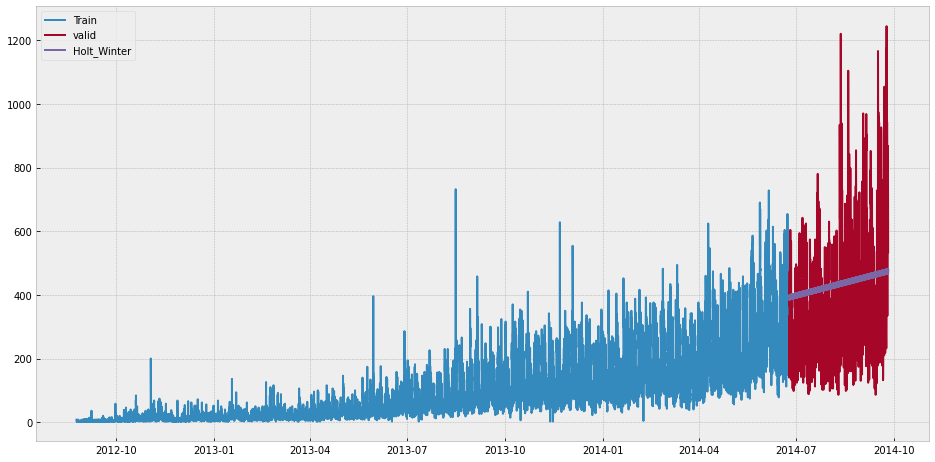

In [49]:
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'],label ='Train')
plt.plot(valid['Count'],label ='valid')
plt.plot(y_hat_avg['Holt_Winter'], label ='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [50]:
#Check the rmse
rms =sqrt(mse(valid.Count, y_hat_avg.Holt_Winter))
print(rms)


185.19460579656976


In [51]:
predict = fit1.forecast(len(test))

In [52]:
test['prediction'] = predict

In [53]:
test

ID            Datetime  year  month  day  Hour  \
Datetime                                                                 
2014-09-26 00:00:00  18288 2014-09-26 00:00:00  2014      9   26     0   
2014-09-26 01:00:00  18289 2014-09-26 01:00:00  2014      9   26     1   
2014-09-26 02:00:00  18290 2014-09-26 02:00:00  2014      9   26     2   
2014-09-26 03:00:00  18291 2014-09-26 03:00:00  2014      9   26     3   
2014-09-26 04:00:00  18292 2014-09-26 04:00:00  2014      9   26     4   
...                    ...                 ...   ...    ...  ...   ...   
2015-04-26 19:00:00  23395 2015-04-26 19:00:00  2015      4   26    19   
2015-04-26 20:00:00  23396 2015-04-26 20:00:00  2015      4   26    20   
2015-04-26 21:00:00  23397 2015-04-26 21:00:00  2015      4   26    21   
2015-04-26 22:00:00  23398 2015-04-26 22:00:00  2015      4   26    22   
2015-04-26 23:00:00  23399 2015-04-26 23:00:00  2015      4   26    23   

                     prediction  
Datetime                         
2014-09-26 00:00:00  385.177298  
2014-09-26 01:00:00  386.419533  
2014-09-26 02:00:00  390.443838  
2014-09-26 03:00:00  392.510162  
2014-09-26 04:00:00  399.140667  
...                         ...  
2015-04-26 19:00:00  587.023638  
2015-04-26 20:00:00  576.816475  
2015-04-26 21:00:00  576.663560  
2015-04-26 22:00:00  573.317996  
2015-04-26 23:00:00  574.560231  

[5112 rows x 7 columns]

In [54]:
prediction = pd.merge(test, temp2, on =('Hour'), how ='left')
prediction

ID            Datetime  year  month  day  Hour  prediction     ratio
0     18288 2014-09-26 00:00:00  2014      9   26     0  385.177298  0.044287
1     18289 2014-09-26 01:00:00  2014      9   26     1  386.419533  0.035343
2     18290 2014-09-26 02:00:00  2014      9   26     2  390.443838  0.029911
3     18291 2014-09-26 03:00:00  2014      9   26     3  392.510162  0.024714
4     18292 2014-09-26 04:00:00  2014      9   26     4  399.140667  0.020802
...     ...                 ...   ...    ...  ...   ...         ...       ...
5107  23395 2015-04-26 19:00:00  2015      4   26    19  587.023638  0.055627
5108  23396 2015-04-26 20:00:00  2015      4   26    20  576.816475  0.053455
5109  23397 2015-04-26 21:00:00  2015      4   26    21  576.663560  0.049895
5110  23398 2015-04-26 22:00:00  2015      4   26    22  573.317996  0.050076
5111  23399 2015-04-26 23:00:00  2015      4   26    23  574.560231  0.048892

[5112 rows x 8 columns]

In [55]:
#convert ratio to the original scale
prediction['Count'] = round((prediction['prediction']* prediction['ratio']*24),1)
prediction

ID            Datetime  year  month  day  Hour  prediction     ratio  \
0     18288 2014-09-26 00:00:00  2014      9   26     0  385.177298  0.044287   
1     18289 2014-09-26 01:00:00  2014      9   26     1  386.419533  0.035343   
2     18290 2014-09-26 02:00:00  2014      9   26     2  390.443838  0.029911   
3     18291 2014-09-26 03:00:00  2014      9   26     3  392.510162  0.024714   
4     18292 2014-09-26 04:00:00  2014      9   26     4  399.140667  0.020802   
...     ...                 ...   ...    ...  ...   ...         ...       ...   
5107  23395 2015-04-26 19:00:00  2015      4   26    19  587.023638  0.055627   
5108  23396 2015-04-26 20:00:00  2015      4   26    20  576.816475  0.053455   
5109  23397 2015-04-26 21:00:00  2015      4   26    21  576.663560  0.049895   
5110  23398 2015-04-26 22:00:00  2015      4   26    22  573.317996  0.050076   
5111  23399 2015-04-26 23:00:00  2015      4   26    23  574.560231  0.048892   

      Count  
0     409.4  
1     327.8  
2     280.3  
3     232.8  
4     199.3  
...     ...  
5107  783.7  
5108  740.0  
5109  690.5  
5110  689.0  
5111  674.2  

[5112 rows x 9 columns]

In [56]:
#drop the unecessary colums 
submission = prediction.drop(['Datetime', 'day','year','month','Hour', 'ratio', 'prediction'], axis = 1)
submission

ID  Count
0     18288  409.4
1     18289  327.8
2     18290  280.3
3     18291  232.8
4     18292  199.3
...     ...    ...
5107  23395  783.7
5108  23396  740.0
5109  23397  690.5
5110  23398  689.0
5111  23399  674.2

[5112 rows x 2 columns]

In [57]:
#convert submission data frame to csv
pd.DataFrame(submission, columns =['ID','Count']).to_csv('submission1.csv', index = False)

## SARIMAX Model on daily time series
### This will take into account the seasonalities of the time series. So we will build a sarimax model on the time series. 

In [58]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log


In [59]:
y_hat_avg = valid.copy()
fit3 = sm.tsa.statespace.SARIMAX(Train.Count, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97927D+00    |proj g|=  7.52765D-02

At iterate    5    f=  4.91987D+00    |proj g|=  2.36143D-02

At iterate   10    f=  4.81662D+00    |proj g|=  9.04821D-03

At iterate   15    f=  4.80756D+00    |proj g|=  3.30522D-02

At iterate   20    f=  4.80166D+00    |proj g|=  6.64041D-02

At iterate   25    f=  4.77975D+00    |proj g|=  1.68537D-02

At iterate   30    f=  4.77912D+00    |proj g|=  3.13074D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

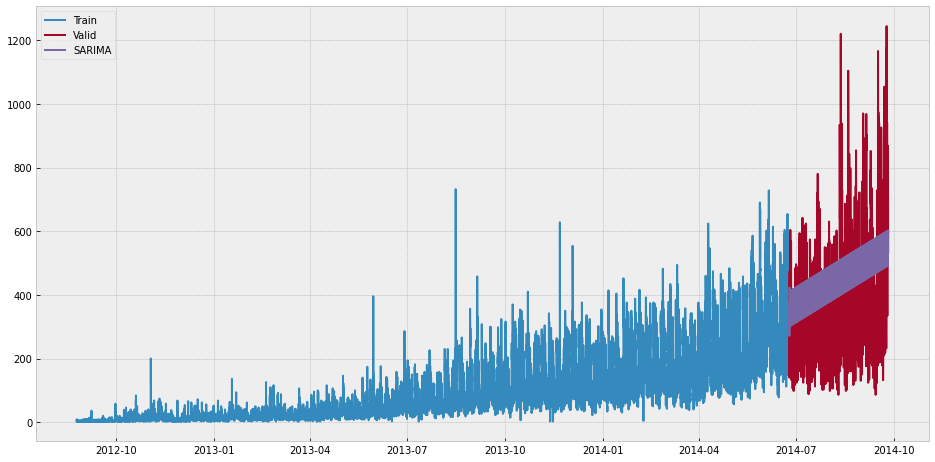

In [60]:
#visualize the model
y_hat_avg['SARIMA'] =fit3.predict(start='2014-06-25', end ='2014-09-26', dynamic =True)
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [61]:
rms =sqrt(mse(valid.Count, y_hat_avg.SARIMA))
print(rms)

177.08057093096858


In [62]:
predict3 = fit3.predict(start='2014-09-26', end ='2015-04-27', dynamic =True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [63]:
test['prediction'] = predict3

In [64]:
prediction = pd.merge(test, temp2, on =('Hour'), how ='left')
prediction 

ID            Datetime  year  month  day  Hour   prediction     ratio
0     18288 2014-09-26 00:00:00  2014      9   26     0   583.722507  0.044287
1     18289 2014-09-26 01:00:00  2014      9   26     1   534.280040  0.035343
2     18290 2014-09-26 02:00:00  2014      9   26     2   534.091391  0.029911
3     18291 2014-09-26 03:00:00  2014      9   26     3   513.741271  0.024714
4     18292 2014-09-26 04:00:00  2014      9   26     4   499.472294  0.020802
...     ...                 ...   ...    ...  ...   ...          ...       ...
5107  23395 2015-04-26 19:00:00  2015      4   26    19   961.037419  0.055627
5108  23396 2015-04-26 20:00:00  2015      4   26    20   973.869700  0.053455
5109  23397 2015-04-26 21:00:00  2015      4   26    21   986.685582  0.049895
5110  23398 2015-04-26 22:00:00  2015      4   26    22  1042.663023  0.050076
5111  23399 2015-04-26 23:00:00  2015      4   26    23  1038.943285  0.048892

[5112 rows x 8 columns]

In [65]:
#convert ratio to the original scale
prediction['Count'] = round((prediction['prediction']* prediction['ratio']*24),1)
prediction

ID            Datetime  year  month  day  Hour   prediction  \
0     18288 2014-09-26 00:00:00  2014      9   26     0   583.722507   
1     18289 2014-09-26 01:00:00  2014      9   26     1   534.280040   
2     18290 2014-09-26 02:00:00  2014      9   26     2   534.091391   
3     18291 2014-09-26 03:00:00  2014      9   26     3   513.741271   
4     18292 2014-09-26 04:00:00  2014      9   26     4   499.472294   
...     ...                 ...   ...    ...  ...   ...          ...   
5107  23395 2015-04-26 19:00:00  2015      4   26    19   961.037419   
5108  23396 2015-04-26 20:00:00  2015      4   26    20   973.869700   
5109  23397 2015-04-26 21:00:00  2015      4   26    21   986.685582   
5110  23398 2015-04-26 22:00:00  2015      4   26    22  1042.663023   
5111  23399 2015-04-26 23:00:00  2015      4   26    23  1038.943285   

         ratio   Count  
0     0.044287   620.4  
1     0.035343   453.2  
2     0.029911   383.4  
3     0.024714   304.7  
4     0.020802   249.4  
...        ...     ...  
5107  0.055627  1283.0  
5108  0.053455  1249.4  
5109  0.049895  1181.5  
5110  0.050076  1253.1  
5111  0.048892  1219.1  

[5112 rows x 9 columns]

In [66]:
submission = prediction.drop(['Datetime', 'day','year','month','Hour', 'ratio', 'prediction'], axis = 1)
submission

ID   Count
0     18288   620.4
1     18289   453.2
2     18290   383.4
3     18291   304.7
4     18292   249.4
...     ...     ...
5107  23395  1283.0
5108  23396  1249.4
5109  23397  1181.5
5110  23398  1253.1
5111  23399  1219.1

[5112 rows x 2 columns]

In [67]:
#convert submission data frame to csv
pd.DataFrame(submission, columns =['ID','Count']).to_csv('submission.csv', index = False)